In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_curve,
    auc
)
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [113]:
# --- 1. Veri Setini Oku ---
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

In [114]:
# --- 2. Kategorik Verileri Encode Et ---
label_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
label_encoder = LabelEncoder()
for col in label_cols:
    df[col] = label_encoder.fit_transform(df[col])

one_hot_cols = ['CAEC', 'CALC', 'MTRANS']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

In [115]:
# Hedef değişken encode etme
df['NObeyesdad'] = label_encoder.fit_transform(df['NObeyesdad'])
class_names = label_encoder.classes_

In [116]:
# --- 3. Yeni Özellik: BMI Hesapla ve Ekle ---
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

In [117]:
# --- 3. Sayısal Verileri Ölçeklendirme ---
numeric_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

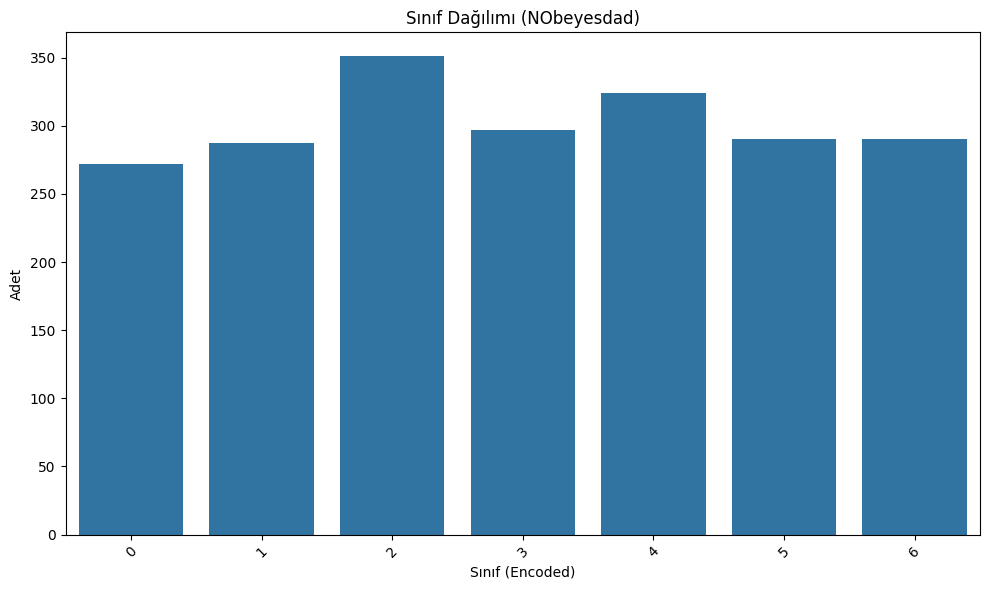

In [118]:
# --- 4. Görselleştirme ---

# 4.1 Sınıf Dağılımı
plt.figure(figsize=(10, 6))
sns.countplot(x='NObeyesdad', data=df)
plt.title("Sınıf Dağılımı (NObeyesdad)")
plt.xlabel("Sınıf (Encoded)")
plt.ylabel("Adet")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


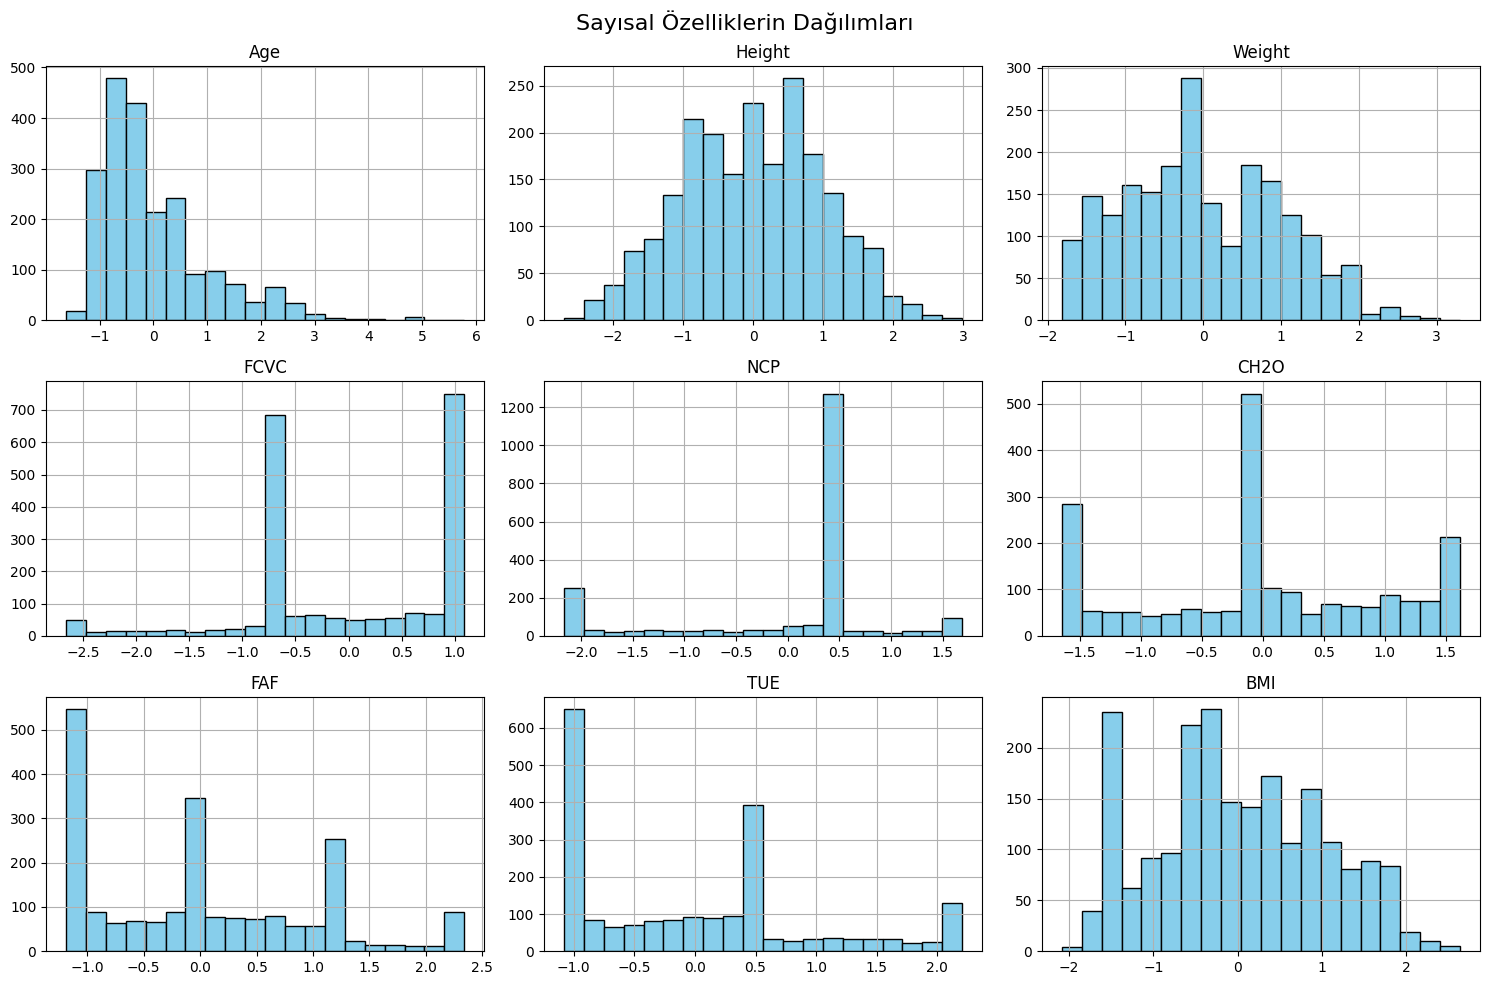

In [119]:
# 4.2 Sayısal Değişkenlerin Histogramları
df[numeric_cols].hist(bins=20, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Sayısal Özelliklerin Dağılımları", fontsize=16)
plt.tight_layout()
plt.show()

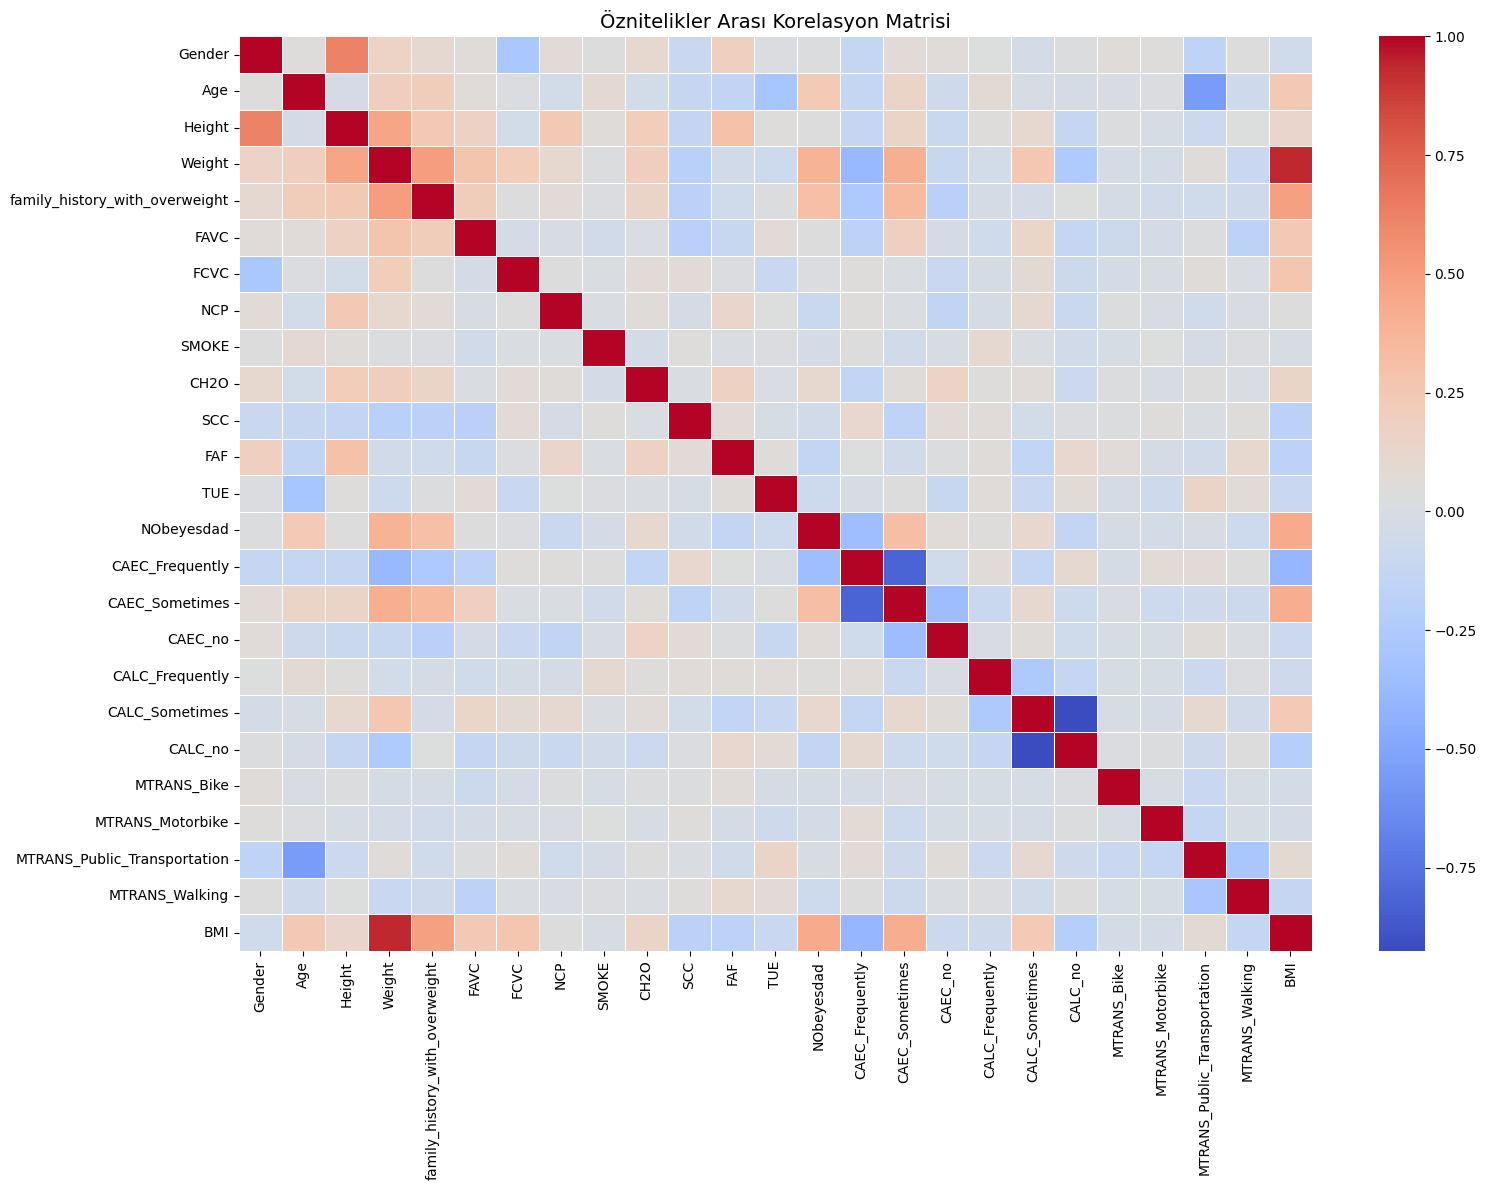

In [120]:
# 4.3 Korelasyon Matrisi
plt.figure(figsize=(16, 12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Öznitelikler Arası Korelasyon Matrisi", fontsize=14)
plt.tight_layout()
plt.show()

In [121]:
# --- 5. Veri Kümesini Eğitim/Test Olarak Ayırma ---
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']
classes = np.unique(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
# --- 6. SMOTE ile Dengeleme (Sadece Eğitim Verisine) ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [123]:
# --- 7. Model Eğitimi (Random Forest) ---
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
original_accuracy = accuracy_score(y_test, y_pred)

print("\n🔍 Orijinal Model Doğruluğu:", original_accuracy)
print(classification_report(y_test, y_pred))


🔍 Orijinal Model Doğruluğu: 0.9905437352245863
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        56
           1       0.94      1.00      0.97        62
           2       1.00      1.00      1.00        78
           3       1.00      1.00      1.00        58
           4       1.00      1.00      1.00        63
           5       1.00      0.95      0.97        56
           6       1.00      1.00      1.00        50

    accuracy                           0.99       423
   macro avg       0.99      0.99      0.99       423
weighted avg       0.99      0.99      0.99       423



In [124]:
# --- 8. Performans Raporu ---
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Doğruluk (Accuracy): 0.9905437352245863
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        56
           1       0.94      1.00      0.97        62
           2       1.00      1.00      1.00        78
           3       1.00      1.00      1.00        58
           4       1.00      1.00      1.00        63
           5       1.00      0.95      0.97        56
           6       1.00      1.00      1.00        50

    accuracy                           0.99       423
   macro avg       0.99      0.99      0.99       423
weighted avg       0.99      0.99      0.99       423



<Figure size 1000x800 with 0 Axes>

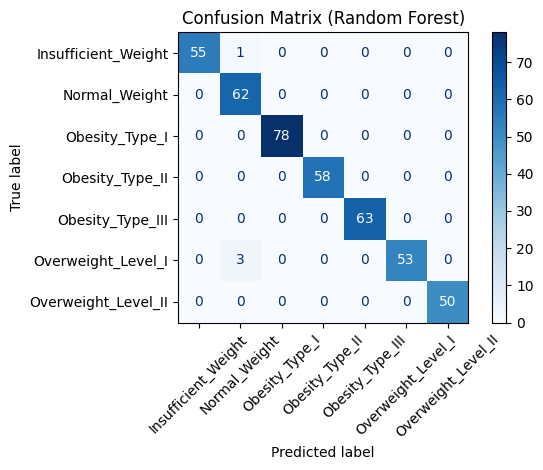

In [125]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix hesapla
cm = confusion_matrix(y_test, y_pred)

# Görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix (Random Forest)")
plt.tight_layout()
plt.show()

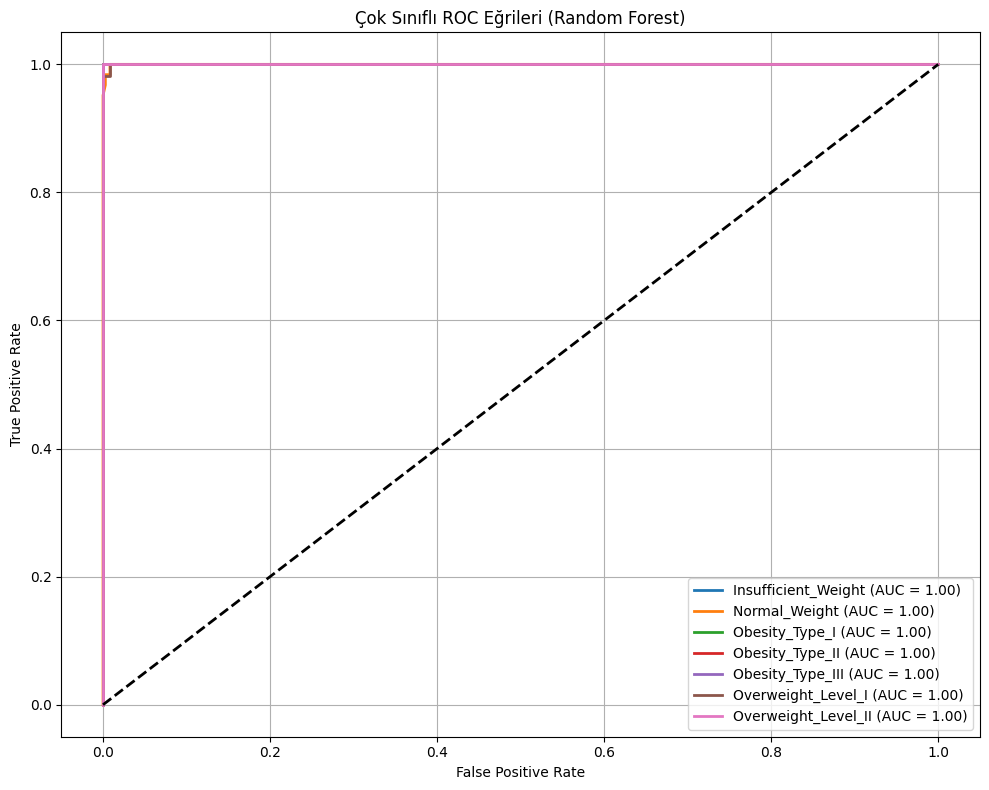

In [126]:
# --- 9. ROC Eğrisi (Çok Sınıflı One-vs-Rest) ---
y_test_bin = label_binarize(y_test, classes=classes)
y_score = clf.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Çok Sınıflı ROC Eğrileri (Random Forest)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


<ipython-input-127-382c674b88b8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Önemi', y='Özellik', data=feat_df.head(15), palette='viridis')


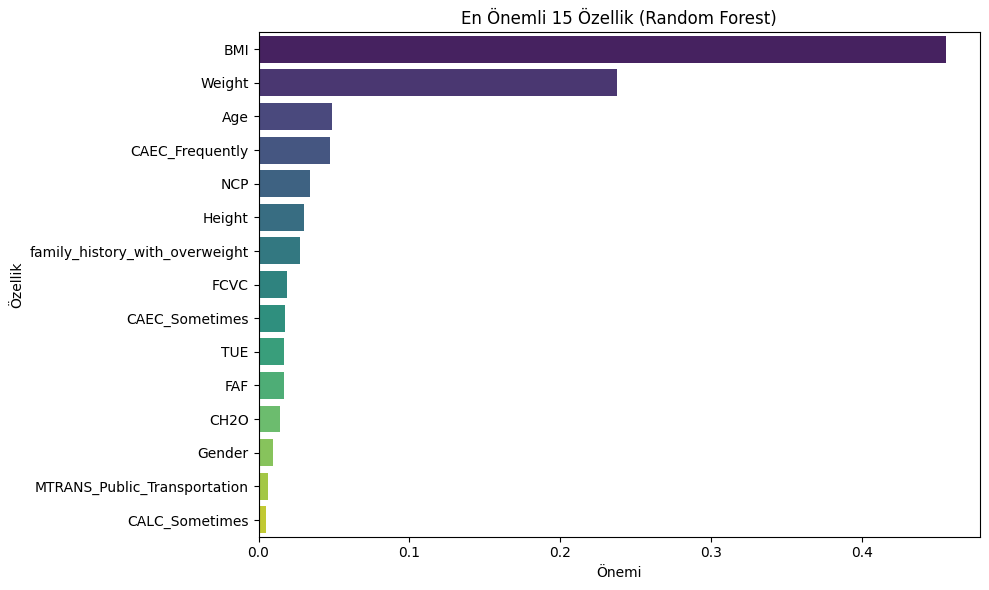

In [127]:
# --- 10. Feature Importance Görselleştirme ---
importances = clf.estimators_[0].feature_importances_  # herhangi bir sınıf modeli alınır
feature_names = X.columns
feat_df = pd.DataFrame({'Özellik': feature_names, 'Önemi': importances})
feat_df = feat_df.sort_values(by='Önemi', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Önemi', y='Özellik', data=feat_df.head(15), palette='viridis')
plt.title("En Önemli 15 Özellik (Random Forest)")
plt.tight_layout()
plt.show()

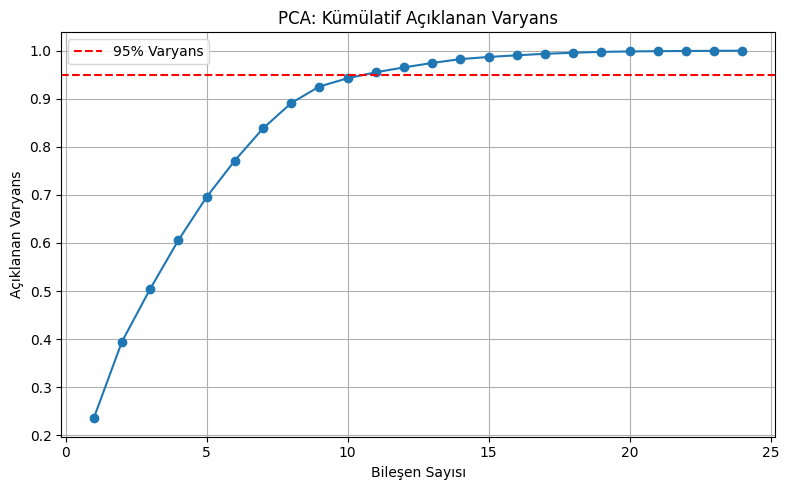

In [128]:
# --- 11. PCA ile Boyut İndirgeme ---
pca = PCA()
pca.fit(X_train_sm)

explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Varyans')
plt.title("PCA: Kümülatif Açıklanan Varyans")
plt.xlabel("Bileşen Sayısı")
plt.ylabel("Açıklanan Varyans")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [129]:
# PCA dönüşümü uygula ve modeli yeniden eğit
# PCA ile 95% varyansı koruyan bileşen sayısını al
n_components = np.argmax(explained >= 0.95) + 1
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_sm)
X_test_pca = pca.transform(X_test)

clf_pca = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf_pca.fit(X_train_pca, y_train_sm)
y_pred_pca = clf_pca.predict(X_test_pca)

pca_accuracy = accuracy_score(y_test, y_pred_pca)

print("\n📊 PCA Uygulanmış Model Doğruluğu:", pca_accuracy)

# --- 12. Karar Mesajı ---
if pca_accuracy > original_accuracy:
    print("✅ PCA uygulanmış model daha iyi performans gösterdi. PCA kullanılabilir.")
else:
    print("❌ PCA uygulanmış model daha düşük performans gösterdi. Orijinal model tercih edilmeli.")



📊 PCA Uygulanmış Model Doğruluğu: 0.8723404255319149
❌ PCA uygulanmış model daha düşük performans gösterdi. Orijinal model tercih edilmeli.
